# Lie Transformations

This notebook illustrates `celmech`'s Lie transformation capabilities with a simple example.

In [1]:
import rebound as rb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.generating_functions import FirstOrderGeneratingFunction
from celmech import Poincare

We set up and integrate a `REBOUND` simulation with a pair of planets near (but not in) a 3:2 mean motion resonance.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


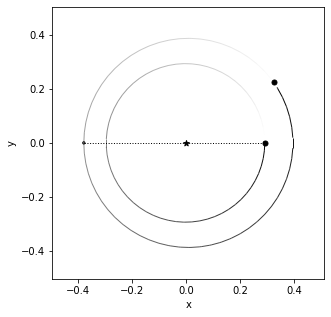

In [2]:
# Set up
sim = rb.Simulation()
sim.add(m=1,hash='star')
sim.add(m=3e-5,P = 1, e = 0.01,l=0)
sim.add(m=3e-5,P = 1.5*(1+0.01), e =0.02,l=np.pi/5,pomega = np.pi)
sim.move_to_com()
rb.OrbitPlot(sim,periastron=True)

# Integrate
sim.automateSimulationArchive('LieTransformationsExample.sa',interval=2.1234,deletefile=True)
sim.integrate(1000)
sa=rb.SimulationArchive('LieTransformationsExample.sa')

Now we'll get a `Poincare` object from our initial simulation state.

In [3]:
pvars = Poincare.from_Simulation(sa[0])

We use this to set up the generating function of our Lie transformation.
Our transformation will eliminate terms associated with the 3:2 MMR to 2nd order in eccentricity, terms associated with the 2:1 and 4:3 MMRs to 1st order in eccentricity, plus all terms to 0th order in eccentricity

In [4]:
pchi = FirstOrderGeneratingFunction(pvars)
# Add terms we want to eliminate
pchi.add_eccentricity_MMR_terms(3,1,2,update=False)
pchi.add_eccentricity_MMR_terms(2,1,1,update=False)
pchi.add_eccentricity_MMR_terms(4,1,1,update=False)
pchi.add_zeroth_order_term(1,2,update=True)

Now, we'll apply the transformation before initializing a `LaplaceLagrangeSystem` in order to get the secular solution.

In [5]:
from celmech.secular import LaplaceLagrangeSystem
# Apply transformation
pchi.osculating_to_mean()

# Initialize LaplaceLagrangeSystem
llsys = LaplaceLagrangeSystem.from_Poincare(pvars)

# Include the effects of the 3:2 MMR on the secular evolution at 2nd order in planet masses.
llsys.add_first_order_resonance_term(1,2,3)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


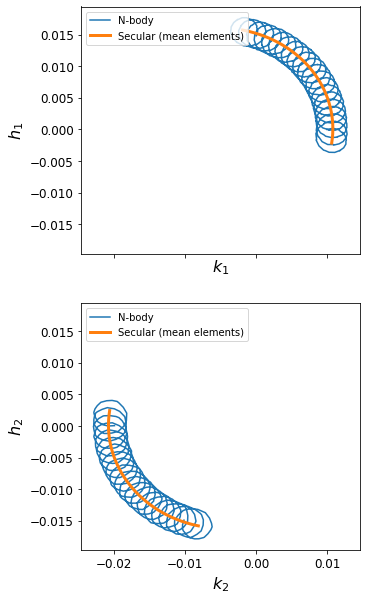

In [6]:
nbresults = get_simarchive_integration_results(sa,coordinates='heliocentric')
ll_soln = llsys.secular_solution(nbresults['time'])
nbresults['z'] = nbresults['e'] * np.exp(1j * nbresults['pomega'])

nbresults['k']=np.real(nbresults['z'])
nbresults['h']=np.imag(nbresults['z'])

fig,ax = plt.subplots(2,figsize=(5,10),sharex=True,sharey=True)
for i,a in enumerate(ax):
    a.plot(nbresults['k'][i],nbresults['h'][i],label='N-body')
    a.plot(ll_soln['k'][i],ll_soln['h'][i],lw=3,label='Secular (mean elements)')
    a.set_xlabel(r'$k_{}$'.format(i+1),fontsize=16)
    a.set_ylabel(r'$h_{}$'.format(i+1),fontsize=16)
    a.legend(loc='upper left')
    plt.sca(a)
    plt.tick_params(labelsize=12)
    

Text(0.5, 0, 'Time')

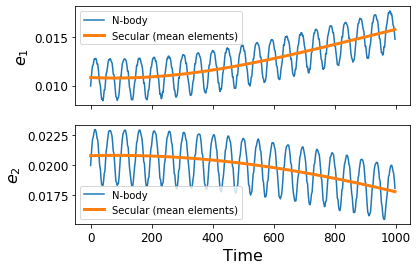

In [7]:
fig,ax = plt.subplots(2,sharex=True)
for i,a in enumerate(ax):
    a.plot(nbresults['time'],nbresults['e'][i],label='N-body')
    a.plot(ll_soln['time'],ll_soln['e'][i],lw=3,label='Secular (mean elements)')
    a.legend()
    plt.sca(a)
    plt.tick_params(labelsize=12)
    a.set_ylabel(r'$e_{}$'.format(i+1),fontsize=16)
a.set_xlabel(r'Time',fontsize=16)